# University of Aberdeen

## Applied AI (CS5079)

### Tutorial (Day 3) - Reinforcement Learning with OpenAI Gym

---

The practical is inspired from the code on: https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb


## Learning Outcomes

On successful completion of this component a student will have demonstrated competence in creating and training an agent to play an Atari game using the screen frames as input

### In this tutorial, we will use the following libraries and modules

In [ ]:
!pip install git+https://github.com/openai/baselines.git


In [1]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# Import the Keras backend used for freeing the global state
# to avoid clutter
from tensorflow.keras import backend as K

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack
from tensorflow import keras
from tensorflow.keras import layers

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym
FRAME_STACK_SIZE = 3
env = gym.make("Asterix-v0")
env = NoopResetEnv(env, noop_max=30)
env = wrap_deepmind(env, frame_stack=False, scale=True, clip_rewards=False, episode_life=False)
env = FrameStack(env, FRAME_STACK_SIZE)
env.seed(SEED_VALUE)
# I have installed pyglet-1.5.11 for it work with BigSur

c:\program files\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\program files\python38\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1337, 17452119]

## Atari Games

In this tutorial, we will create an agent to play the Boxing Atari game. In this game, two boxers, one white and one black, compete against each other. When close enough, a boxer can hit his opponent with a punch which causes his opponent to reel back slightly. A match is completed either when one player lands 100 punches or two minutes have elapsed. In the case of a decision, the player with the most landed punches is the winner. Ties are possible. 

![Activision's Boxing Cartridge](img/Boxing.png)

In this tutorial, we will use the pixels as inputs. The OpenAI Gym environment is `Boxing-v0`. 

### Naive Agent
1.1. For the boxing game, describe the observations, the action space, the reward, the environment’s info dictionary and the episode.


In [2]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())

Observation space: Box(84, 84, 3)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


The observation space is an RGB picture of size 210x160 whereas the action space is composed of the 18 possible moves from an ATARI controller. The info dictionary contains `ale.lives()` which refers to the number of lives left (but here there is no finite number of lives).

1.2. Create a simple agent that performs random actions.

### Deep Q-Learning Agent

1.3. Implement a pre-processing function to convert the $210\times160$ RGB frames to $96\times80$ greyscale frames. Then, change the type of the matrix to `int8`.


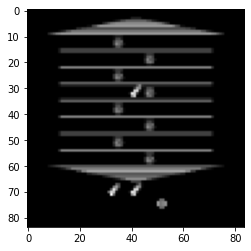

In [3]:
obs = env.reset()
from skimage.color import rgb2gray

# def preprocess_observation(observation):
#     img = observation[23:153:2, ::2] # This becomes 90, 80, 3
# #     print(img.shape)
# #     print(img.shape)
# #     img = img.mean(axis=2) #to grayscale (values between 0 and 255)
#     img = rgb2gray(img)
#     img = img.astype(np.float32) # normalize from -128 to 127
#     return img.reshape(65, 80)


plt.imshow(obs[:,:,0], cmap='gray')
plt.show()

1.4. Create a function `q_network` that (1) takes as input a variable of shape $(96,80,1)$, (2) creates a deep convolutional network with 3 convolutional hidden layers and two dense layers, and (3) returns the output layer and the trainable variables in a dictionary where the keys are the name of the variables.

In [4]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    # Release the global state to avoid clutter
    # when creating models (in loops etc.)
#     K.clear_session()
    
    # Reset the Tensorflow graph
#     tf.compat.v1.reset_default_graph()
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

In [5]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

INPUT_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
BATCH_SIZE = 32
MEMORY_SIZE = 25000
MIN_REPLAY_SIZE = 20000
LEARNING_RATE = 0.00025

1.5. Create an agent `QLearningAgent` with two deep convolutional networks (`online` and `target`) to predict the action to be taken from the game's frames. The `online` network will be trained and replace the `target`network every $5000$ training steps.


1.6. Create a method `get_action` using a parameter $\epsilon$ for making random moves. This parameter will decrease from $1$ to $0.1$.

1.7. Create a method `train` to update the weights of the `online` network using the Q-values of the `target` network. We will use a discount rate of $0.99$. 

In [6]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros( 2*capacity - 1 )
        self.data = np.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [7]:
#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._getPriority(error)
        self.tree.add(p, sample) 

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [8]:
from collections import deque
import math

MAX_EPSILON = 1
MIN_EPSILON = 0.1
LAMBDA = - math.log(0.01) / MIN_REPLAY_SIZE  # speed of decay

class QLearningAgent():
    def __init__(self, env, lr=LEARNING_RATE):
        self.lr = lr
        
        self.memory = Memory(MEMORY_SIZE)
        
        self.loss_val = np.inf
        self.action_size = NUM_ACTIONS
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99
        self.checkpoint_path = "./my_dqn.ckpt"

        # Create the two networks for predicting the actions
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 5000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64, units=256):
        """Define and return the CNN model architecture
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()
        model.add(Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        model.add(Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init))
        model.add(Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * step)
        if step <= MIN_REPLAY_SIZE or np.random.rand() < epsilon:
            return np.random.randint(self.action_size) # random action
        else:
            q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
            return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        
        no_state = np.zeros(INPUT_SHAPE)
        
        prev_states = np.array([obs[1][0] for obs in batch])
        
        # No state if done = True
        next_states = np.array([(no_state if obs[1][4] is True else obs[1][3]) for obs in batch])
    
        prev_q_vals = self.online.predict(prev_states)
        next_q_vals = self.target.predict(next_states)
        
        X = np.zeros((len(batch), *INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Unpack the current batch sample
            curr_state, action, reward, next_state, done = batch[idx][1]
            
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value
            future_q_val = q_val
            
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + np.amax(next_q_vals[idx]) * self.discount_rate
            
            X[idx] = curr_state
            Y[idx] = future_q_val
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return (X, Y, errors)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done):
        
        sample = (curr_state, action, reward, next_state, done)
        X, Y, errors = self.get_train_data([(0, sample)])
        self.memory.add(errors[0], sample)
        
    def train(self, step):
        """Train the online model and update the loss value
        """
        
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        if step <= MIN_REPLAY_SIZE:
            return
        
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [ ]:
import time
agent = QLearningAgent(env)  
ep_rewards = []
total_reward = 0
n_steps = 1000000  # total number of training steps
save_steps = 50


# Train the model after 4 actions
train_online_steps = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
update_target_steps = 10000

done=True
for step in range(n_steps):
    total_perc = step * 100 / n_steps
    print(f"\r\tAction step: {step}/{n_steps} ({total_perc:.2f}%)\tLoss: {agent.loss_val:5f}", end="")
    if done: # game over, start again
        avg_reward = int(total_reward/3)
        if total_reward:
            ep_rewards.append(total_reward)
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        state = np.array(env.reset())
        total_reward = 0
#         state = preprocess_observation(obs)


    # Get a exploration/exploitation action depending on the
    # current epsilon value
#     q_values = agent.online.predict(state)
    action = agent.get_action(state, step)

    # Online DQN plays
    next_state, reward, done, info = env.step(action)

    next_state = np.array(next_state)
    
#     next_state = preprocess_observation(next_obs)
    agent.save_to_memory(state, action, reward, next_state, done)
    
    if step % train_online_steps == 0:
        agent.train(step)

    # Regularly copy the online DQN to the target DQN
    if step % update_target_steps == 0:
        agent.update_target()
    
    env.render()
    total_reward += reward
    state = next_state
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan


c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 278/1000000 (0.03%)	Loss:   inf	AVG reward: 33	Total mean: 100.0
	Action step: 629/1000000 (0.06%)	Loss:   inf	AVG reward: 100	Total mean: 200.0
	Action step: 921/1000000 (0.09%)	Loss:   inf	AVG reward: 116	Total mean: 250.0
	Action step: 1513/1000000 (0.15%)	Loss:   inf	AVG reward: 200	Total mean: 337.5
	Action step: 1821/1000000 (0.18%)	Loss:   inf	AVG reward: 66	Total mean: 310.0
	Action step: 2427/1000000 (0.24%)	Loss:   inf	AVG reward: 283	Total mean: 400.0
	Action step: 2707/1000000 (0.27%)	Loss:   inf	AVG reward: 33	Total mean: 357.14285714285717
	Action step: 3154/1000000 (0.32%)	Loss:   inf	AVG reward: 100	Total mean: 350.0
	Action step: 3424/1000000 (0.34%)	Loss:   inf	AVG reward: 33	Total mean: 322.22222222222223
	Action step: 3774/1000000 (0.38%)	Loss:   inf	AVG reward: 116	Total mean: 325.0
	Action step: 4092/1000000 (0.41%)	Loss:   inf	AVG reward: 66	Total mean: 313.6363636363636
	Action step: 4600/1000000 (0.46%)	Loss:   inf	AVG reward: 150	Total mean: 325.

	Action step: 30016/1000000 (3.00%)	Loss: 0.462110	AVG reward: 116	Total mean: 237.77777777777777
	Action step: 30272/1000000 (3.03%)	Loss: 0.423947	AVG reward: 50	Total mean: 236.8131868131868
	Action step: 30593/1000000 (3.06%)	Loss: 0.777650	AVG reward: 83	Total mean: 236.95652173913044
	Action step: 31060/1000000 (3.11%)	Loss: 0.390186	AVG reward: 100	Total mean: 237.63440860215053
	Action step: 31392/1000000 (3.14%)	Loss: 0.702472	AVG reward: 133	Total mean: 239.36170212765958
	Action step: 31775/1000000 (3.18%)	Loss: 0.556230	AVG reward: 50	Total mean: 238.42105263157896
	Action step: 32167/1000000 (3.22%)	Loss: 0.471511	AVG reward: 133	Total mean: 240.10416666666666
	Action step: 32436/1000000 (3.24%)	Loss: 0.609644	AVG reward: 83	Total mean: 240.20618556701032
	Action step: 32702/1000000 (3.27%)	Loss: 0.450873	AVG reward: 16	Total mean: 238.26530612244898
	Action step: 33105/1000000 (3.31%)	Loss: 0.882916	AVG reward: 150	Total mean: 240.40404040404042
	Action step: 33521/100000

	Action step: 59838/1000000 (5.98%)	Loss: 0.466276	AVG reward: 100	Total mean: 267.7142857142857
	Action step: 60083/1000000 (6.01%)	Loss: 0.710507	AVG reward: 83	Total mean: 267.6136363636364
	Action step: 60529/1000000 (6.05%)	Loss: 0.392586	AVG reward: 200	Total mean: 269.49152542372883
	Action step: 60822/1000000 (6.08%)	Loss: 0.655236	AVG reward: 100	Total mean: 269.6629213483146
	Action step: 61189/1000000 (6.12%)	Loss: 0.575928	AVG reward: 83	Total mean: 269.55307262569835
	Action step: 61470/1000000 (6.15%)	Loss: 0.365248	AVG reward: 66	Total mean: 269.1666666666667
	Action step: 61847/1000000 (6.18%)	Loss: 0.721127	AVG reward: 150	Total mean: 270.16574585635357
	Action step: 62443/1000000 (6.24%)	Loss: 0.510871	AVG reward: 250	Total mean: 272.8021978021978
	Action step: 62703/1000000 (6.27%)	Loss: 0.331780	AVG reward: 83	Total mean: 272.6775956284153
	Action step: 63087/1000000 (6.31%)	Loss: 0.401752	AVG reward: 150	Total mean: 273.64130434782606
	Action step: 63356/1000000 (6

	Action step: 89305/1000000 (8.93%)	Loss: 0.832322	AVG reward: 166	Total mean: 279.61538461538464
	Action step: 89581/1000000 (8.96%)	Loss: 0.555427	AVG reward: 83	Total mean: 279.50191570881225
	Action step: 89877/1000000 (8.99%)	Loss: 0.401408	AVG reward: 66	Total mean: 279.19847328244276
	Action step: 90153/1000000 (9.02%)	Loss: 0.455700	AVG reward: 50	Total mean: 278.70722433460077
	Action step: 90631/1000000 (9.06%)	Loss: 0.646913	AVG reward: 116	Total mean: 278.97727272727275
	Action step: 90871/1000000 (9.09%)	Loss: 0.927730	AVG reward: 33	Total mean: 278.3018867924528
	Action step: 91105/1000000 (9.11%)	Loss: 0.417001	AVG reward: 66	Total mean: 278.0075187969925
	Action step: 91362/1000000 (9.14%)	Loss: 0.776296	AVG reward: 66	Total mean: 277.71535580524346
	Action step: 91973/1000000 (9.20%)	Loss: 0.809078	AVG reward: 183	Total mean: 278.7313432835821
	Action step: 92307/1000000 (9.23%)	Loss: 0.553067	AVG reward: 66	Total mean: 278.4386617100372
	Action step: 92785/1000000 (9.

	Action step: 117242/1000000 (11.72%)	Loss: 0.546618	AVG reward: 116	Total mean: 279.06976744186045
	Action step: 117500/1000000 (11.75%)	Loss: 0.654699	AVG reward: 100	Total mean: 279.1304347826087
	Action step: 117939/1000000 (11.79%)	Loss: 0.592480	AVG reward: 150	Total mean: 279.6242774566474
	Action step: 118336/1000000 (11.83%)	Loss: 0.518323	AVG reward: 166	Total mean: 280.2593659942363
	Action step: 118580/1000000 (11.86%)	Loss: 0.504126	AVG reward: 50	Total mean: 279.88505747126436
	Action step: 118917/1000000 (11.89%)	Loss: 0.356648	AVG reward: 116	Total mean: 280.08595988538684
	Action step: 119166/1000000 (11.92%)	Loss: 0.622977	AVG reward: 33	Total mean: 279.57142857142856
	Action step: 119429/1000000 (11.94%)	Loss: 0.480475	AVG reward: 66	Total mean: 279.34472934472933
	Action step: 119681/1000000 (11.97%)	Loss: 0.547422	AVG reward: 66	Total mean: 279.1193181818182
	Action step: 119914/1000000 (11.99%)	Loss: 0.403071	AVG reward: 16	Total mean: 278.4702549575071
	Action st

	Action step: 171087/1000000 (17.11%)	Loss: 0.616374	AVG reward: 50	Total mean: 280.29411764705884
	Action step: 171457/1000000 (17.15%)	Loss: 0.619003	AVG reward: 100	Total mean: 280.3326810176125
	Action step: 172005/1000000 (17.20%)	Loss: 0.846094	AVG reward: 166	Total mean: 280.76171875
	Action step: 172279/1000000 (17.23%)	Loss: 1.053795	AVG reward: 50	Total mean: 280.5068226120858
	Action step: 172563/1000000 (17.26%)	Loss: 0.917038	AVG reward: 116	Total mean: 280.6420233463035
	Action step: 172822/1000000 (17.28%)	Loss: 0.802208	AVG reward: 50	Total mean: 280.3883495145631
	Action step: 173278/1000000 (17.33%)	Loss: 0.528665	AVG reward: 150	Total mean: 280.7170542635659
	Action step: 173554/1000000 (17.36%)	Loss: 0.465661	AVG reward: 83	Total mean: 280.6576402321083
	Action step: 173766/1000000 (17.38%)	Loss: 0.652065	AVG reward: 66	Total mean: 280.5019305019305
	Action step: 174045/1000000 (17.40%)	Loss: 1.020594	AVG reward: 83	Total mean: 280.4431599229287
	Action step: 174581

	Action step: 224931/1000000 (22.49%)	Loss: 0.774042	AVG reward: 83	Total mean: 284.44444444444446
	Action step: 225311/1000000 (22.53%)	Loss: 1.144017	AVG reward: 133	Total mean: 284.61538461538464
	Action step: 225785/1000000 (22.58%)	Loss: 0.842683	AVG reward: 116	Total mean: 284.711964549483
	Action step: 226067/1000000 (22.61%)	Loss: 0.927588	AVG reward: 66	Total mean: 284.58702064896755
	Action step: 226313/1000000 (22.63%)	Loss: 0.835481	AVG reward: 33	Total mean: 284.31516936671574
	Action step: 226714/1000000 (22.67%)	Loss: 0.477412	AVG reward: 200	Total mean: 284.77941176470586
	Action step: 226957/1000000 (22.70%)	Loss: 0.551887	AVG reward: 83	Total mean: 284.7283406754772
	Action step: 227492/1000000 (22.75%)	Loss: 1.027907	AVG reward: 283	Total mean: 285.55718475073314
	Action step: 227796/1000000 (22.78%)	Loss: 0.678625	AVG reward: 83	Total mean: 285.5051244509517
	Action step: 228110/1000000 (22.81%)	Loss: 0.615206	AVG reward: 116	Total mean: 285.59941520467834
	Action s

	Action step: 281856/1000000 (28.19%)	Loss: 0.697702	AVG reward: 133	Total mean: 292.8486293206198
	Action step: 282074/1000000 (28.21%)	Loss: 0.785408	AVG reward: 33	Total mean: 292.6190476190476
	Action step: 282304/1000000 (28.23%)	Loss: 1.059720	AVG reward: 66	Total mean: 292.5089179548157
	Action step: 282580/1000000 (28.26%)	Loss: 0.635800	AVG reward: 100	Total mean: 292.51781472684087
	Action step: 282962/1000000 (28.30%)	Loss: 0.986144	AVG reward: 133	Total mean: 292.64531435349943
	Action step: 283298/1000000 (28.33%)	Loss: 0.734907	AVG reward: 133	Total mean: 292.77251184834125
	Action step: 283521/1000000 (28.35%)	Loss: 0.872524	AVG reward: 50	Total mean: 292.603550295858
	Action step: 283818/1000000 (28.38%)	Loss: 0.912273	AVG reward: 66	Total mean: 292.49408983451536
	Action step: 284163/1000000 (28.42%)	Loss: 0.767217	AVG reward: 100	Total mean: 292.5029515938607
	Action step: 284410/1000000 (28.44%)	Loss: 0.331879	AVG reward: 66	Total mean: 292.3938679245283
	Action step

	Action step: 309816/1000000 (30.98%)	Loss: 0.702945	AVG reward: 100	Total mean: 295.2225841476656
	Action step: 310361/1000000 (31.04%)	Loss: 0.825148	AVG reward: 183	Total mean: 295.49891540130153
	Action step: 310864/1000000 (31.09%)	Loss: 0.805913	AVG reward: 166	Total mean: 295.7204767063922
	Action step: 311136/1000000 (31.11%)	Loss: 1.018509	AVG reward: 33	Total mean: 295.508658008658
	Action step: 311390/1000000 (31.14%)	Loss: 0.334286	AVG reward: 83	Total mean: 295.4594594594595
	Action step: 311828/1000000 (31.18%)	Loss: 0.930518	AVG reward: 216	Total mean: 295.8423326133909
	Action step: 312677/1000000 (31.27%)	Loss: 0.771065	AVG reward: 350	Total mean: 296.65587918015103
	Action step: 313160/1000000 (31.32%)	Loss: 0.773015	AVG reward: 116	Total mean: 296.7133620689655
	Action step: 313700/1000000 (31.37%)	Loss: 0.941121	AVG reward: 133	Total mean: 296.82454251883746
	Action step: 314059/1000000 (31.41%)	Loss: 0.489254	AVG reward: 83	Total mean: 296.7741935483871
	Action ste

	Action step: 339356/1000000 (33.94%)	Loss: 0.843330	AVG reward: 83	Total mean: 298.5044865403789
	Action step: 339759/1000000 (33.98%)	Loss: 0.499825	AVG reward: 150	Total mean: 298.6553784860558
	Action step: 340030/1000000 (34.00%)	Loss: 0.814592	AVG reward: 50	Total mean: 298.5074626865672
	Action step: 340320/1000000 (34.03%)	Loss: 0.698864	AVG reward: 116	Total mean: 298.558648111332
	Action step: 340601/1000000 (34.06%)	Loss: 0.931211	AVG reward: 83	Total mean: 298.51042701092354
	Action step: 340855/1000000 (34.09%)	Loss: 0.844705	AVG reward: 116	Total mean: 298.56150793650795
	Action step: 341199/1000000 (34.12%)	Loss: 0.691725	AVG reward: 133	Total mean: 298.66204162537167
	Action step: 341480/1000000 (34.15%)	Loss: 0.541646	AVG reward: 100	Total mean: 298.66336633663366
	Action step: 341891/1000000 (34.19%)	Loss: 0.571059	AVG reward: 183	Total mean: 298.91196834817015
	Action step: 342273/1000000 (34.23%)	Loss: 0.584251	AVG reward: 100	Total mean: 298.9130434782609
	Action s

	Action step: 370557/1000000 (37.06%)	Loss: 0.902887	AVG reward: 116	Total mean: 306.2730627306273
	Action step: 371003/1000000 (37.10%)	Loss: 0.877145	AVG reward: 133	Total mean: 306.3594470046083
	Action step: 371737/1000000 (37.17%)	Loss: 0.453981	AVG reward: 250	Total mean: 306.76795580110496
	Action step: 372008/1000000 (37.20%)	Loss: 0.866287	AVG reward: 116	Total mean: 306.80772769089236
	Action step: 372262/1000000 (37.23%)	Loss: 1.004573	AVG reward: 83	Total mean: 306.7555147058824
	Action step: 372603/1000000 (37.26%)	Loss: 0.540716	AVG reward: 100	Total mean: 306.74931129476585
	Action step: 372897/1000000 (37.29%)	Loss: 0.933971	AVG reward: 66	Total mean: 306.651376146789
	Action step: 373161/1000000 (37.32%)	Loss: 0.466567	AVG reward: 50	Total mean: 306.50779101741523
	Action step: 373514/1000000 (37.35%)	Loss: 0.807839	AVG reward: 83	Total mean: 306.45604395604397
	Action step: 373842/1000000 (37.38%)	Loss: 0.739157	AVG reward: 83	Total mean: 306.40439158279963
	Action st

	Action step: 399686/1000000 (39.97%)	Loss: 0.629781	AVG reward: 33	Total mean: 307.76824034334766
	Action step: 399986/1000000 (40.00%)	Loss: 0.927733	AVG reward: 133	Total mean: 307.8473413379074
	Action step: 400395/1000000 (40.04%)	Loss: 0.958835	AVG reward: 150	Total mean: 307.96915167095113
	Action step: 400847/1000000 (40.08%)	Loss: 0.867622	AVG reward: 150	Total mean: 308.0907534246575
	Action step: 401115/1000000 (40.11%)	Loss: 0.889234	AVG reward: 50	Total mean: 307.95551753635584
	Action step: 401378/1000000 (40.14%)	Loss: 0.736445	AVG reward: 100	Total mean: 307.94871794871796
	Action step: 401685/1000000 (40.17%)	Loss: 0.823566	AVG reward: 66	Total mean: 307.85653287788216
	Action step: 401982/1000000 (40.20%)	Loss: 0.733818	AVG reward: 100	Total mean: 307.84982935153585
	Action step: 402457/1000000 (40.25%)	Loss: 0.443812	AVG reward: 150	Total mean: 307.9710144927536
	Action step: 402850/1000000 (40.28%)	Loss: 0.768182	AVG reward: 150	Total mean: 308.09199318568994
	Actio

	Action step: 429586/1000000 (42.96%)	Loss: 0.976045	AVG reward: 133	Total mean: 309.2696629213483
	Action step: 429836/1000000 (42.98%)	Loss: 0.753101	AVG reward: 16	Total mean: 309.0617481956696
	Action step: 430400/1000000 (43.04%)	Loss: 0.520390	AVG reward: 166	Total mean: 309.2147435897436
	Action step: 430799/1000000 (43.08%)	Loss: 0.667514	AVG reward: 116	Total mean: 309.2473979183347
	Action step: 431095/1000000 (43.11%)	Loss: 0.347482	AVG reward: 116	Total mean: 309.28
	Action step: 431600/1000000 (43.16%)	Loss: 0.658989	AVG reward: 183	Total mean: 309.4724220623501
	Action step: 431837/1000000 (43.18%)	Loss: 0.640981	AVG reward: 66	Total mean: 309.3849840255591
	Action step: 432097/1000000 (43.21%)	Loss: 1.135254	AVG reward: 66	Total mean: 309.2976855546688
	Action step: 432526/1000000 (43.25%)	Loss: 0.552702	AVG reward: 116	Total mean: 309.33014354066984
	Action step: 432796/1000000 (43.28%)	Loss: 0.835586	AVG reward: 66	Total mean: 309.2430278884462
	Action step: 433239/100

	Action step: 462205/1000000 (46.22%)	Loss: 0.819294	AVG reward: 183	Total mean: 311.5500376222724
	Action step: 462665/1000000 (46.27%)	Loss: 0.917733	AVG reward: 116	Total mean: 311.57894736842104
	Action step: 463245/1000000 (46.32%)	Loss: 0.558120	AVG reward: 100	Total mean: 311.5702479338843
	Action step: 463502/1000000 (46.35%)	Loss: 0.911423	AVG reward: 33	Total mean: 311.4114114114114
	Action step: 463754/1000000 (46.38%)	Loss: 0.490272	AVG reward: 33	Total mean: 311.25281320330083
	Action step: 464298/1000000 (46.43%)	Loss: 0.789536	AVG reward: 166	Total mean: 311.3943028485757
	Action step: 464838/1000000 (46.48%)	Loss: 0.743062	AVG reward: 216	Total mean: 311.6479400749064
	Action step: 465533/1000000 (46.55%)	Loss: 0.566668	AVG reward: 250	Total mean: 311.9760479041916
	Action step: 465935/1000000 (46.59%)	Loss: 0.456181	AVG reward: 133	Total mean: 312.0418848167539
	Action step: 466255/1000000 (46.63%)	Loss: 0.580930	AVG reward: 83	Total mean: 311.99551569506724
	Action st

	Action step: 494745/1000000 (49.47%)	Loss: 0.378546	AVG reward: 16	Total mean: 313.0049610205528
	Action step: 495009/1000000 (49.50%)	Loss: 0.662745	AVG reward: 50	Total mean: 312.8895184135977
	Action step: 495250/1000000 (49.52%)	Loss: 0.705231	AVG reward: 83	Total mean: 312.84501061571126
	Action step: 495502/1000000 (49.55%)	Loss: 0.522567	AVG reward: 50	Total mean: 312.72984441301276
	Action step: 495779/1000000 (49.58%)	Loss: 0.552012	AVG reward: 83	Total mean: 312.6855123674912
	Action step: 496030/1000000 (49.60%)	Loss: 0.951062	AVG reward: 33	Total mean: 312.5353107344633
	Action step: 496287/1000000 (49.63%)	Loss: 0.783510	AVG reward: 83	Total mean: 312.49117854622443
	Action step: 496730/1000000 (49.67%)	Loss: 0.851485	AVG reward: 133	Total mean: 312.5528913963329
	Action step: 497094/1000000 (49.71%)	Loss: 0.700819	AVG reward: 150	Total mean: 312.64975334742775
	Action step: 497439/1000000 (49.74%)	Loss: 0.646197	AVG reward: 116	Total mean: 312.67605633802816
	Action step

	Action step: 527521/1000000 (52.75%)	Loss: 0.464575	AVG reward: 83	Total mean: 313.66376423308776
	Action step: 528072/1000000 (52.81%)	Loss: 0.661419	AVG reward: 183	Total mean: 313.8219544846051
	Action step: 528876/1000000 (52.89%)	Loss: 0.958131	AVG reward: 216	Total mean: 314.04682274247494
	Action step: 529160/1000000 (52.92%)	Loss: 0.619446	AVG reward: 83	Total mean: 314.00401069518716
	Action step: 529471/1000000 (52.95%)	Loss: 0.855906	AVG reward: 50	Total mean: 313.8944555778223
	Action step: 530088/1000000 (53.01%)	Loss: 0.795377	AVG reward: 150	Total mean: 313.9853137516689
	Action step: 530392/1000000 (53.04%)	Loss: 0.825976	AVG reward: 50	Total mean: 313.87591727818545
	Action step: 531085/1000000 (53.11%)	Loss: 0.426455	AVG reward: 116	Total mean: 313.9
	Action step: 531589/1000000 (53.16%)	Loss: 0.987351	AVG reward: 233	Total mean: 314.1572285143238
	Action step: 531852/1000000 (53.19%)	Loss: 0.550001	AVG reward: 50	Total mean: 314.0479360852197
	Action step: 532213/10

	Action step: 589153/1000000 (58.92%)	Loss: 0.574509	AVG reward: 66	Total mean: 316.25452352231605
	Action step: 589575/1000000 (58.96%)	Loss: 0.812048	AVG reward: 166	Total mean: 316.36528028933094
	Action step: 590015/1000000 (59.00%)	Loss: 0.744017	AVG reward: 150	Total mean: 316.4457831325301
	Action step: 590433/1000000 (59.04%)	Loss: 0.823415	AVG reward: 183	Total mean: 316.5863937387116
	Action step: 590725/1000000 (59.07%)	Loss: 0.851008	AVG reward: 66	Total mean: 316.51624548736464
	Action step: 591068/1000000 (59.11%)	Loss: 0.908667	AVG reward: 83	Total mean: 316.4762477450391
	Action step: 591511/1000000 (59.15%)	Loss: 0.673079	AVG reward: 216	Total mean: 316.6766826923077
	Action step: 591750/1000000 (59.17%)	Loss: 0.755262	AVG reward: 0	Total mean: 316.6766826923077
	Action step: 592153/1000000 (59.22%)	Loss: 0.496074	AVG reward: 50	Total mean: 316.5765765765766
	Action step: 592428/1000000 (59.24%)	Loss: 0.476784	AVG reward: 33	Total mean: 316.44657863145255
	Action step:

	Action step: 620031/1000000 (62.00%)	Loss: 0.849973	AVG reward: 83	Total mean: 316.41748131109836
	Action step: 620310/1000000 (62.03%)	Loss: 1.071464	AVG reward: 33	Total mean: 316.2931034482759
	Action step: 620646/1000000 (62.06%)	Loss: 0.517069	AVG reward: 100	Total mean: 316.2837449741528
	Action step: 620906/1000000 (62.09%)	Loss: 1.032189	AVG reward: 100	Total mean: 316.2743972445465
	Action step: 621188/1000000 (62.12%)	Loss: 0.913139	AVG reward: 66	Total mean: 316.20768789443486
	Action step: 621883/1000000 (62.19%)	Loss: 0.765006	AVG reward: 316	Total mean: 316.5711009174312
	Action step: 622179/1000000 (62.22%)	Loss: 0.884678	AVG reward: 50	Total mean: 316.4756446991404
	Action step: 622427/1000000 (62.24%)	Loss: 0.357307	AVG reward: 16	Total mean: 316.3230240549828
	Action step: 622745/1000000 (62.27%)	Loss: 0.575364	AVG reward: 133	Total mean: 316.3709215798512
	Action step: 623121/1000000 (62.31%)	Loss: 1.170498	AVG reward: 100	Total mean: 316.3615560640732
	Action step:

	Action step: 677161/1000000 (67.72%)	Loss: 0.648745	AVG reward: 83	Total mean: 316.82464454976304
	Action step: 677417/1000000 (67.74%)	Loss: 0.555530	AVG reward: 83	Total mean: 316.7894736842105
	Action step: 677860/1000000 (67.79%)	Loss: 0.946525	AVG reward: 200	Total mean: 316.93845344555496
	Action step: 678346/1000000 (67.83%)	Loss: 0.691160	AVG reward: 166	Total mean: 317.0347003154574
	Action step: 678620/1000000 (67.86%)	Loss: 0.795590	AVG reward: 50	Total mean: 316.9469259064635
	Action step: 679221/1000000 (67.92%)	Loss: 0.748256	AVG reward: 183	Total mean: 317.0693277310924
	Action step: 679597/1000000 (67.96%)	Loss: 0.784172	AVG reward: 200	Total mean: 317.2178477690289
	Action step: 680038/1000000 (68.00%)	Loss: 0.661105	AVG reward: 100	Total mean: 317.208814270724
	Action step: 680249/1000000 (68.02%)	Loss: 0.459466	AVG reward: 100	Total mean: 317.1997902464604
	Action step: 680792/1000000 (68.08%)	Loss: 1.018312	AVG reward: 83	Total mean: 317.164570230608
	Action step: 

	Action step: 708257/1000000 (70.83%)	Loss: 0.755192	AVG reward: 0	Total mean: 317.9707218576477
	Action step: 708559/1000000 (70.86%)	Loss: 0.806466	AVG reward: 83	Total mean: 317.9364278506559
	Action step: 708931/1000000 (70.89%)	Loss: 0.483696	AVG reward: 116	Total mean: 317.95259707513867
	Action step: 709356/1000000 (70.94%)	Loss: 1.001637	AVG reward: 166	Total mean: 318.0443548387097
	Action step: 709780/1000000 (70.98%)	Loss: 0.332262	AVG reward: 100	Total mean: 318.0352644836272
	Action step: 710106/1000000 (71.01%)	Loss: 0.672203	AVG reward: 16	Total mean: 317.90030211480365
	Action step: 710431/1000000 (71.04%)	Loss: 0.371847	AVG reward: 133	Total mean: 317.9416205334675
	Action step: 710950/1000000 (71.09%)	Loss: 0.573687	AVG reward: 216	Total mean: 318.1086519114688
	Action step: 711206/1000000 (71.12%)	Loss: 0.651140	AVG reward: 83	Total mean: 318.07440925087985
	Action step: 711587/1000000 (71.16%)	Loss: 0.621900	AVG reward: 150	Total mean: 318.14070351758795
	Action ste

	Action step: 739226/1000000 (73.92%)	Loss: 0.652192	AVG reward: 33	Total mean: 318.96802325581393
	Action step: 739565/1000000 (73.96%)	Loss: 0.873358	AVG reward: 83	Total mean: 318.9346246973366
	Action step: 740002/1000000 (74.00%)	Loss: 0.728978	AVG reward: 133	Total mean: 318.973862536302
	Action step: 740571/1000000 (74.06%)	Loss: 0.702382	AVG reward: 233	Total mean: 319.1582002902758
	Action step: 741033/1000000 (74.10%)	Loss: 0.658496	AVG reward: 100	Total mean: 319.1489361702128
	Action step: 741409/1000000 (74.14%)	Loss: 0.780029	AVG reward: 133	Total mean: 319.1880135331078
	Action step: 741871/1000000 (74.19%)	Loss: 0.716059	AVG reward: 150	Total mean: 319.2512077294686
	Action step: 742573/1000000 (74.26%)	Loss: 1.218693	AVG reward: 266	Total mean: 319.4833413809754
	Action step: 742861/1000000 (74.29%)	Loss: 0.792584	AVG reward: 116	Total mean: 319.4980694980695
	Action step: 743407/1000000 (74.34%)	Loss: 0.822208	AVG reward: 283	Total mean: 319.75397973950794
	Action ste

	Action step: 769338/1000000 (76.93%)	Loss: 0.669245	AVG reward: 116	Total mean: 320.8197484862599
	Action step: 769647/1000000 (76.96%)	Loss: 0.767269	AVG reward: 100	Total mean: 320.8100558659218
	Action step: 770187/1000000 (77.02%)	Loss: 0.880192	AVG reward: 183	Total mean: 320.91670544439273
	Action step: 770489/1000000 (77.05%)	Loss: 1.110999	AVG reward: 100	Total mean: 320.90697674418607
	Action step: 770891/1000000 (77.09%)	Loss: 1.002764	AVG reward: 83	Total mean: 320.8740120874012
	Action step: 771286/1000000 (77.13%)	Loss: 1.342536	AVG reward: 50	Total mean: 320.7946096654275
	Action step: 771696/1000000 (77.17%)	Loss: 0.752915	AVG reward: 166	Total mean: 320.87784486762655
	Action step: 772086/1000000 (77.21%)	Loss: 0.909679	AVG reward: 133	Total mean: 320.9145775301764
	Action step: 772339/1000000 (77.23%)	Loss: 0.773281	AVG reward: 66	Total mean: 320.8584686774942
	Action step: 772729/1000000 (77.27%)	Loss: 0.992587	AVG reward: 150	Total mean: 320.9183673469388
	Action st

In [ ]:
print(ep_rewards)

1.8. Print the evolution of the total number of rewards w.r.t. the episodes.

1.9. Analyse the behaviour of the saved agents, can you notice any emerging strategies?

https://www.youtube.com/watch?v=OxOqLQ8Ed_k

In [ ]:
np.stack([1,2,3]).reshape(3,1)

In [ ]:
import pandas as pd
x = pd.DataFrame(data=ep_rewards)

In [ ]:


plt.rcParams['figure.figsize']= (20,6)
plt.plot(ep_rewards)
plt.show()

In [ ]:
x['sum'].plot()

In [ ]:
x.to_csv('model_300.csv')